<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Dropout, Reshape, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Data Preprocessing

---



## Load Data

In [2]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)

In [3]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

Type of ecg5000: 	 	 <class 'pandas.core.frame.DataFrame'>
Dimensions of ecg5000: 	 	 (5000, 141)
Number of elements of ecg5000: 	 705000
Display first 10 rows of ecg5000: 
    0         1         2         3    ...       137       138       139       140
0  1.0 -0.112522 -2.827204 -3.773897  ...  0.228077  0.123431  0.925286  0.193137
1  1.0 -1.100878 -3.996840 -4.285843  ...  0.476333  0.773820  1.119621 -1.436250
2  1.0 -0.567088 -2.593450 -3.874230  ... -0.532197  0.321097  0.904227 -0.421797
3  1.0  0.490473 -1.914407 -3.616364  ...  0.990133  1.086798  1.403011 -0.383564
4  1.0  0.800232 -0.874252 -2.384761  ...  0.960304  0.971020  1.614392  1.421456
5  1.0 -1.507674 -3.574550 -4.478011  ...  1.007076  1.634990  1.493366 -0.783134
6  1.0 -0.297161 -2.766635 -4.102185  ...  0.974787  1.110407  1.288165 -0.823386
7  1.0  0.446769 -1.507397 -3.187468  ...  1.034388  1.258433  0.961215 -0.999476
8  1.0  0.087631 -1.753490 -3.304473  ...  0.573453  0.192971 -0.648683 -2.441068
9  1.0

In [4]:
### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
print(scaled_ecg5000)

      0         1         2         3    ...       137       138       139       140
0    -0.8  0.105202 -0.154680 -0.521072  ...  0.183241  0.190712  0.256566 -0.054755
1    -0.8 -0.030005 -0.331729 -0.626180  ...  0.231023  0.305374  0.286734 -0.247949
2    -0.8  0.043017 -0.119297 -0.541672  ...  0.036911  0.225560  0.253297 -0.127667
3    -0.8  0.187692 -0.016509 -0.488729  ...  0.329914  0.360551  0.330726 -0.123133
4    -0.8  0.230067  0.140940 -0.235867  ...  0.324173  0.340140  0.363540  0.090885
...   ...       ...       ...       ...  ...       ...       ...       ...       ...
4995  0.4 -0.033027 -0.067751 -0.335005  ... -0.632409 -0.337752 -0.198844 -0.292066
4996 -0.4  0.045669 -0.012746 -0.329288  ...  0.369043  0.391322  0.291519  0.017785
4997 -0.4 -0.064328 -0.061103 -0.263680  ... -0.522184 -0.229486 -0.132008 -0.158819
4998 -0.4 -0.033227 -0.015091 -0.196437  ... -0.103605  0.090797  0.026031 -0.064782
4999 -0.4  0.220296  0.302430  0.103076  ...  0.476928  0.440269 

## Split Data

In [5]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(scaled_ecg5000, test_size=0.2, shuffle=False)

# Get all labels from trainDF and then drop it
trainDF_Y = trainDF.iloc[:,0]
trainDF.drop(trainDF.columns[[0]], axis=1, inplace=True)

# Get all labels from testDF and then drop it
testDF_Y = testDF.iloc[:,0]
testDF.drop(testDF.columns[[0]], axis=1, inplace=True)

# Optional test and info about new data sets
print("Shape of Train DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))
print("Shape of Train Y DataFrame: \t {}".format(trainDF_Y.shape))
print("Shape of Test Y DataFrame: \t {}".format(testDF_Y.shape))

Shape of Train DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)
Shape of Train Y DataFrame: 	 (4000,)
Shape of Test Y DataFrame: 	 (1000,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Reshape Data

In [6]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

y_train = trainDF_Y.to_numpy()
y_test = testDF_Y.to_numpy()

### Reshape datasets X/Y train/test into [samples, timesteps, features]
s_xtrain = len(trainDF.index) # samples
n_xtrain = len(trainDF.columns) # time steps

s_xtest = len(testDF.index) # samples
n_xtest = len(testDF.columns) # time steps

s_ytrain = len(trainDF_Y.index) # samples

s_ytest = len(testDF_Y.index) # samples

x_train = x_train.reshape(s_xtrain, n_xtrain, 1)
x_test = x_test.reshape(s_xtest, n_xtest, 1)

y_train = y_train.reshape(s_ytrain, 1, 1)
y_test = y_test.reshape(s_ytest, 1, 1)

### Properties
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))

print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (4000, 140, 1)
Shape of x_test: (1000, 140, 1)
Shape of y_train: (4000, 1, 1)
Shape of y_test: (1000, 1, 1)


# Create Sample Layer

---



In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Variational Autoencoder (VAE)

---



## Encoder

In [8]:
def create_encoder(encoding_dim=140, intermediate_dim=140, latent_dim=5, activation='tanh', dropout_rate=0.2, regulazier_rate=0.001): # maybe delete encoding and latent dim, do something with input shape
    ### Define Layers
    encoder_inputs = keras.Input(shape=(140, 1), name='Encoder_Input_layer')

    encoded = Bidirectional(LSTM(intermediate_dim, activation=activation, name=''), name='Encode_1')(encoder_inputs)
    encoded = Dropout(dropout_rate, name='Dropout_1')(encoded)
    encoded = Dense(latent_dim, activation=activation, name='Encode_2', kernel_regularizer=l2(regulazier_rate), bias_regularizer=l2(regulazier_rate), activity_regularizer=l2(regulazier_rate))(encoded)

    z_mean = Dense(latent_dim, activation="softplus", name="z_mean")(encoded)
    #z_mean = BatchNormalization()(z_mean)  

    z_log_var = Dense(latent_dim, activation="softplus", name="z_log_var")(encoded)
    #z_log_var = BatchNormalization()(z_log_var)

    z = Sampling(name='Sample_layer')([z_mean, z_log_var])

    ### Instantiate encoder
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

In [9]:
### Check if encoder works
encoder = create_encoder() 
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
Encode_1 (Bidirectional)        (None, 280)          159040      Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 280)          0           Encode_1[0][0]                   
__________________________________________________________________________________________________
Encode_2 (Dense)                (None, 5)            1405        Dropout_1[0][0]                  
____________________________________________________________________________________________

## Decoder

In [10]:
def create_decoder(encoding_dim=140, intermediate_dim=140, latent_dim=5, activation='tanh', dropout_rate=0.2, regulazier_rate=0.001): # maybe delete encoding and latent dim, do something with input shape
    ### Define Layers
    latent_inputs = keras.Input(shape=(latent_dim,), name='Decoder_Input_layer')

    decoded = Dense(encoding_dim, activation=activation, name='Decode_1', kernel_regularizer=l2(regulazier_rate), bias_regularizer=l2(regulazier_rate), activity_regularizer=l2(regulazier_rate))(latent_inputs)
    decoded = Reshape((140,1), name='Decode_2')(decoded)
    decoded = Dropout(dropout_rate, name='Dropout_1')(decoded)
    decoded = Bidirectional(LSTM(intermediate_dim, activation=activation, return_sequences=True, name=''), name='Decode_3')(decoded)

    decoder_outputs = TimeDistributed(Dense(1, activation=activation, name=''),name='Decoder_Output_Layer')(decoded)

    ### Instantiate decoder
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

In [11]:
### Check if decoder works
decoder = create_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input_layer (InputLa [(None, 5)]               0         
_________________________________________________________________
Decode_1 (Dense)             (None, 140)               840       
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 1)            0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 140, 1)            0         
_________________________________________________________________
Decode_3 (Bidirectional)     (None, 140, 280)          159040    
_________________________________________________________________
Decoder_Output_Layer (TimeDi (None, 140, 1)            281       
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_____________________________________________________

## VAE

Define VAE Model

In [12]:
# try the different definition here with the sum of reduce mean : https://keras.io/examples/generative/vae/

class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstruction_loss = distance between Input and Output
            reconstruction_loss = tf.reduce_mean(
                # keras.losses.binary_crossentropy(data, reconstruction)
                keras.losses.mean_squared_error(data, reconstruction)
            )
            # kl_loss = distance between distributions and thus ensures the regular laten space
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            # kl_loss = tf.reduce_mean(kl_loss)
            # kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstructed = self.decoder(z)
        return reconstructed

Build VAE connecting Encoder and Decoder

In [13]:
### Function to create model, required for KerasClassifier
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='SGD'
def create_model(activation='tanh', intermediate_dim=140, dropout_rate=0.2, regulazier_rate=0.001, optimizer='adam', learn_rate=0.001, name='VAE'):
    # create encoder 
    encoder = create_encoder(activation=activation, intermediate_dim=intermediate_dim, dropout_rate=dropout_rate, regulazier_rate=regulazier_rate)
    # create decoder 
    decoder = create_decoder(activation=activation, intermediate_dim=intermediate_dim, dropout_rate=dropout_rate, regulazier_rate=regulazier_rate)
    # create vae
    model = VAE(encoder, decoder, name=name)
    # compile model
    if optimizer == 'adam':
      opt = Adam(lr=learn_rate)
    else:
      opt = SGD(lr=learn_rate)
    model.compile(optimizer=opt)
    model.build((None,140,1))
    
    return model

In [14]:
### Instantiate VAE model
vae = create_model(name='VAE')

### Display VAE model and it`s parts
# encoder 
vae.encoder.summary(line_length=100)
plot_model(vae.encoder, show_shapes=True, to_file='reconstruct_lstm_encoder.png')
print("\n")
# decoder
vae.decoder.summary(line_length=100)
plot_model(vae.decoder, show_shapes=True, to_file='reconstruct_lstm_decoder.png')
print("\n")
# vae
vae.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Encoder_Input_layer (InputLayer) [(None, 140, 1)]      0                                            
____________________________________________________________________________________________________
Encode_1 (Bidirectional)         (None, 280)           159040      Encoder_Input_layer[0][0]        
____________________________________________________________________________________________________
Dropout_1 (Dropout)              (None, 280)           0           Encode_1[0][0]                   
____________________________________________________________________________________________________
Encode_2 (Dense)                 (None, 5)             1405        Dropout_1[0][0]                  
__________________________________________________________________________

# Train VAE

---



In [15]:
### Train Properties
epochs = 12 #60, 100
batch_size = 16 #32

## Train

In [16]:
### To improve training see here: https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d
### Train
train_history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/12
250/250 [==============================] - 17s 29ms/step - loss: 0.1289 - reconstruction_loss: 0.0312 - kl_loss: 0.0977 - val_loss: 0.0357
Epoch 2/12
250/250 [==============================] - 6s 24ms/step - loss: 0.0457 - reconstruction_loss: 0.0257 - kl_loss: 0.0200 - val_loss: 0.0353
Epoch 3/12
250/250 [==============================] - 6s 23ms/step - loss: 0.0331 - reconstruction_loss: 0.0246 - kl_loss: 0.0085 - val_loss: 0.0351
Epoch 4/12
250/250 [==============================] - 6s 24ms/step - loss: 0.0286 - reconstruction_loss: 0.0237 - kl_loss: 0.0049 - val_loss: 0.0350
Epoch 5/12
250/250 [==============================] - 6s 24ms/step - loss: 0.0267 - reconstruction_loss: 0.0234 - kl_loss: 0.0032 - val_loss: 0.0351
Epoch 6/12
250/250 [==============================] - 6s 23ms/step - loss: 0.0255 - reconstruction_loss: 0.0232 - kl_loss: 0.0023 - val_loss: 0.0355
Epoch 7/12
250/250 [==============================] - 6s 24ms/step - loss: 0.0248 - reconstruction_loss: 

In [17]:
print(train_history.history["loss"])

[0.06280194222927094, 0.04744626581668854, 0.042268138378858566, 0.024135347455739975, 0.024983657523989677, 0.021614624187350273, 0.017241813242435455, 0.02421240136027336, 0.026167763397097588, 0.018111564218997955, 0.02033354341983795, 0.01837487332522869]


In [18]:
print(train_history.history["reconstruction_loss"])
print(train_history.history["kl_loss"])
print(train_history.history["val_loss"])

[0.027142448350787163, 0.03570280224084854, 0.03603203594684601, 0.020215429365634918, 0.02228589914739132, 0.019648900255560875, 0.01575196534395218, 0.023050477728247643, 0.02524174191057682, 0.01736103929579258, 0.019717004150152206, 0.017862917855381966]
[0.03565949201583862, 0.011743461713194847, 0.00623610382899642, 0.003919918090105057, 0.002697759075090289, 0.0019657232332974672, 0.0014898478984832764, 0.0011619239812716842, 0.0009260222432203591, 0.0007505245739594102, 0.0006165385129861534, 0.0005119562265463173]
[0.03570566326379776, 0.03529400750994682, 0.03505603224039078, 0.03504899516701698, 0.03510766103863716, 0.03551964461803436, 0.03570897504687309, 0.0359928198158741, 0.036127809435129166, 0.03660112991929054, 0.036653127521276474, 0.03695432096719742]


## Recreate Latent Space

In [19]:
# Encoder output is a list [z_mean, z_log_var, z] thus list[2] = z, see subsection encoder line 12

### Extract myu i.e. z_mean
z_mean = vae.encoder.predict(x_test)[0]
print("----- z_mean: -----")
print(z_mean)
print("\n")

### Extract sigma i.e. z_log_var
z_log_var = vae.encoder.predict(x_test)[1]
print("----- z_log_var: -----")
print(z_log_var)
print("\n")

### Extract z_values and predict x_test
z_values = vae.encoder.predict(x_test)[2]
# decoded_ecg5000 = vae.predict(x_test)
decoded_ecg5000 = vae.decoder.predict(z_values)

# z_values contains list of each z_value per sample, i.e. we get 1000 SubLists with 5 elements in each.
# Those 5 elements (z_values for Sample i) is our bottleneck which the decoder
# recieves.
print("----- z_values: -----")
print(z_values)
print("\n")

### Properties
print("Shape of z_mean: {}".format(z_mean.shape))
print("Shape of z_log_var: {}".format(z_log_var.shape))
print("Shape of decoded_ecg5000: {}".format(decoded_ecg5000.shape))
print("Shape of z_values: {}".format(z_values.shape))

----- z_mean: -----
[[0.01772129 0.00904814 0.02363306 0.01924123 0.02331711]
 [0.01772129 0.00904813 0.02363306 0.01924122 0.02331712]
 [0.01772129 0.00904813 0.02363306 0.01924122 0.02331711]
 ...
 [0.01772129 0.00904813 0.02363306 0.01924122 0.02331712]
 [0.01772129 0.00904813 0.02363306 0.01924122 0.02331711]
 [0.01772129 0.00904813 0.02363305 0.01924122 0.0233171 ]]


----- z_log_var: -----
[[0.03151616 0.00618376 0.04083066 0.04573254 0.04021178]
 [0.03151615 0.00618377 0.04083067 0.04573254 0.04021177]
 [0.03151615 0.00618376 0.04083066 0.04573253 0.04021177]
 ...
 [0.03151615 0.00618377 0.04083066 0.04573253 0.04021177]
 [0.03151616 0.00618377 0.04083066 0.04573254 0.04021177]
 [0.03151615 0.00618376 0.04083066 0.04573253 0.04021177]]


----- z_values: -----
[[-0.72026175 -0.98750895  0.9757672   0.89732844 -1.0412825 ]
 [-0.6246766  -0.0423022   0.1957572   0.26212168  0.8802711 ]
 [ 1.4060367   0.13392788  1.3320669   1.527945   -0.63277286]
 ...
 [-1.6498753   0.3075994   0.

## Display the training progress

Text(0.5, 1.0, 'Loss vs. Reconstruction Loss vs. KL Divergence')

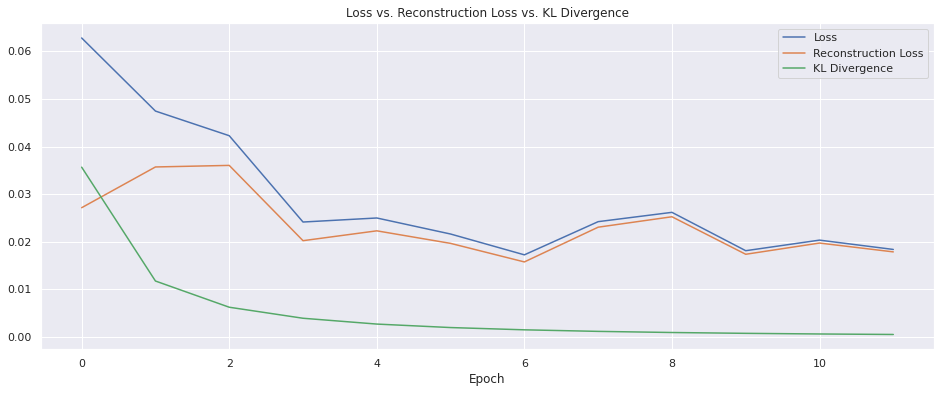

In [20]:
### Loss vs Reconstruction_loss vs KL Divergence
plt.figure(figsize=(16,6))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['reconstruction_loss'])
plt.plot(train_history.history['kl_loss'])
plt.legend(["Loss", "Reconstruction Loss", "KL Divergence"])
plt.xlabel("Epoch")
plt.title("Loss vs. Reconstruction Loss vs. KL Divergence")

Text(0.5, 1.0, 'Loss vs. Validation Loss')

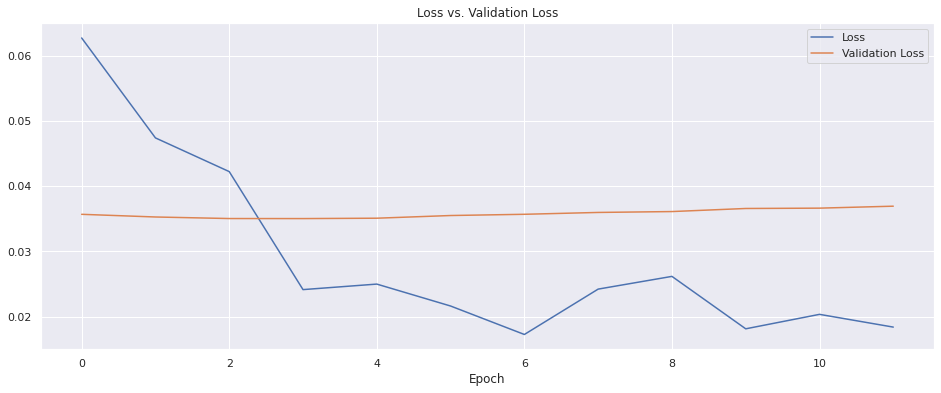

In [21]:
### Train loss vs val loss
#Returns the loss value & metrics values for the model in test mode

plt.figure(figsize=(16,6))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.title("Loss vs. Validation Loss")

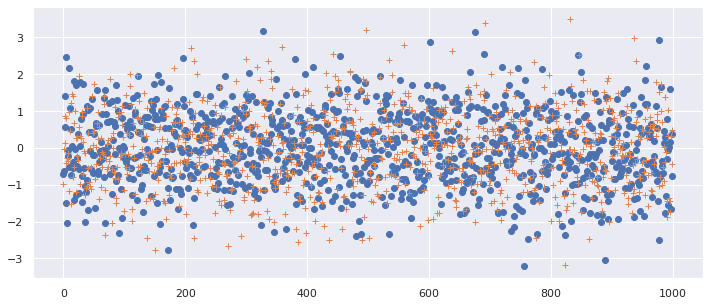

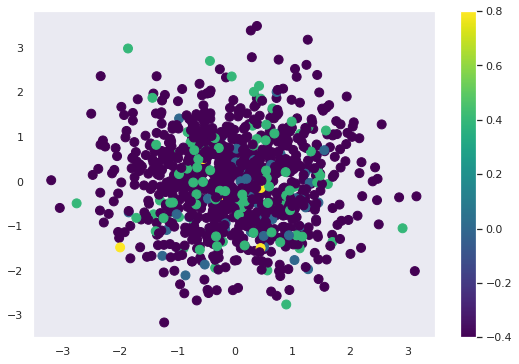

In [22]:
#########################################################To-Do
### Latent space
# x,y Plot
plt.figure(figsize=(12,5), linewidth=1)
plt.plot(z_values[:,0], 'o')
plt.plot(z_values[:,1], '+')
plt.show()

# Scatterplot
plt.figure(figsize=(9,6))
plt.scatter(z_values[:,0], z_values[:,1], s=80, c=y_test, cmap='viridis') # or cmap=hsv
plt.colorbar()
plt.grid()
plt.show()

# Plot Data Results

---



In [23]:
### Test if Input fits Dim of Output
print("Shape of Input x_train: {}".format(x_train.shape))
print("Shape of Output of x_train, decoded_ecg5000: {}".format(decoded_ecg5000.shape))

### Covert to 2D Array -- ("-1" = make a dimension (here rows) the size that will use the remaining unspecified elements)
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print("Shape of Input after reshaping: {}".format(new_x_train.shape))
print("Shape of Output after reshaping: {}".format(new_decoded_ecg5000.shape))

Shape of Input x_train: (4000, 140, 1)
Shape of Output of x_train, decoded_ecg5000: (1000, 140, 1)
Shape of Input after reshaping: (4000, 140)
Shape of Output after reshaping: (1000, 140)


In [24]:
# ### Plot for figure for paper
# i = 934 # indize/sample which is going to be plotted
# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_x_train[i])
# plt.show()
# plt.savefig('diagramm_original.jpg')

# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
# plt.show()
# plt.savefig('diagramm_decoded.jpg')

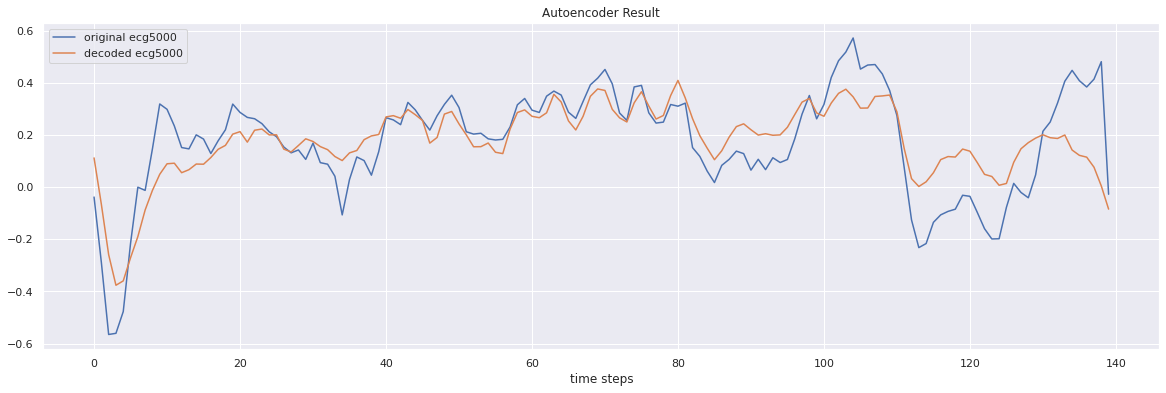

In [25]:
### Plot only one sample
i = 934 # indize/sample which is going to be plotted
plt.figure(linewidth = 1, figsize=(20,6))
plt.title('Autoencoder Result')
plt.xlabel('time steps')
plt.plot(new_x_train[i], label='original ecg5000')
plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
plt.legend(loc="upper left")
plt.show()

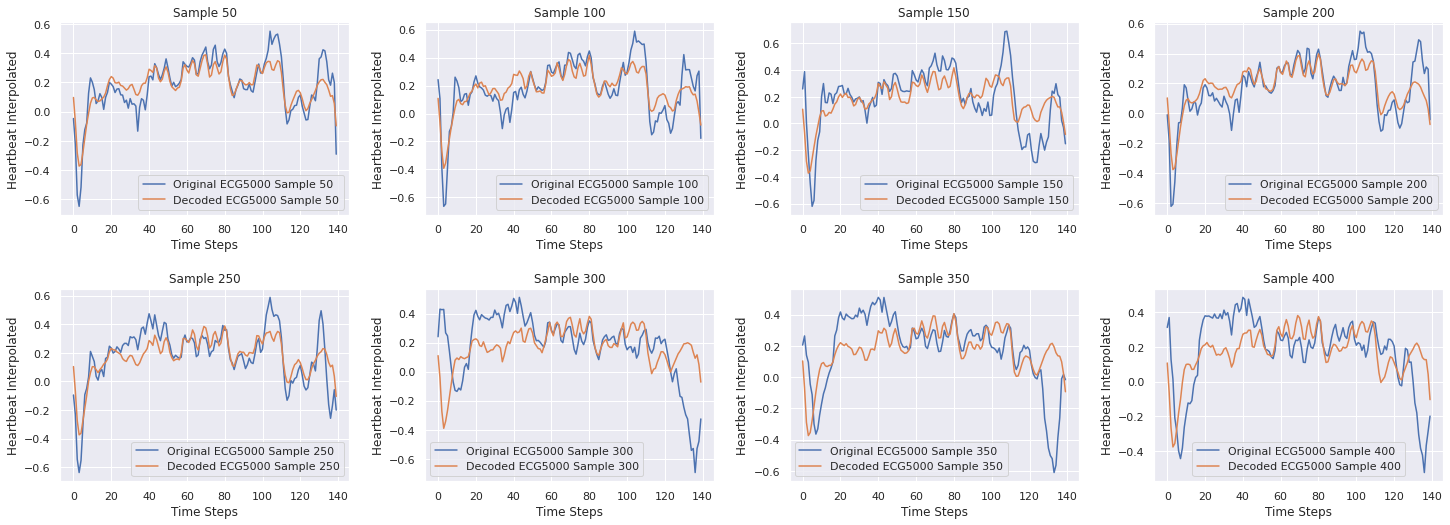

In [26]:
### Plot Multiple Samples
n_rows = 2                   
n_cols = 4

# Size Properties and layout design for tighter representation
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(20,7))
fig.tight_layout(w_pad=4, h_pad = 5)

# Subplotting
i = 50
for row in range(n_rows):
  for col in range(n_cols):
    axs[row, col].plot(new_x_train[i])
    axs[row, col].plot(new_decoded_ecg5000[i])
    axs[row, col].legend(["Original ECG5000 Sample {}".format(i), "Decoded ECG5000 Sample {}".format(i)])
    axs[row, col].set(xlabel = "Time Steps", ylabel = "Heartbeat Interpolated", title = "Sample {}".format(i))
    i = i + 50


# Optimization

---

## Hyperparameter (Sckit_GridSearchCV)

In [27]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [28]:
### Define scorer for gridSearch
def score_mse(y_true, y_pred): # , **kwargs
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    print("Shapes before reshaping: {} for y_true and {} for y_pred".format(y_true.shape, y_pred.shape))
    # removing all size 1 dimensions in y_true
    y_true = tf.squeeze(y_true)
    print("Shapes after reshaping: {} for y_true and {} for y_pred".format(y_true.shape, y_pred.shape))  
    return np.mean(tf.math.squared_difference(y_pred, y_true))

######################################################To-Do: verbose=0 and isplay training in another way thus someone knows how much is left
### Define Function to gridSearch
def gridSearch_pipeline(x_train_data, x_test_data, model, param_grid, cv=10, scoring_fit='neg_mean_squared_error', do_probabilities = False):
    # define gridSearch
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=1, 
        scoring=scoring_fit,
        verbose=1
    )
    # fit model
    fitted_model = gs.fit(x_train_data, x_train_data)
    # get all! results in a dataframe 
    df_result = pd.DataFrame(gs.cv_results_)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(x_test_data)
    else:
      pred = fitted_model.predict(x_test_data)
    
    return fitted_model, pred, df_result

In [29]:
### Define evaluated params and it's value range
param_grid = {
              #'epochs' :              [20, 50],
              'batch_size' :          [16, 32],
              #'activation' :          ['tanh', 'relu'],
              'dropout_rate' :        [0.2, 0.3],
              #'regulazier_rate' :     [0.001,0.004],
              #'optimizer' :           ['Adam', 'SGD'],
              #'learn_rate' :          [0.001, 0.01],
             }

### Wrap keras custom VAE model with the KerasClassifier so it can be used in scikit-learn
# see here how it is wrapped: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
model = KerasRegressor(build_fn=create_model)

### Run GridSearch
#m=make_scorer(mean_squared,greater_is_better=False)
model, pred, df_GSresult = gridSearch_pipeline(x_train, x_test, model, param_grid, scoring_fit=make_scorer(score_mse, greater_is_better=False))

### Summarize results
print("Best: {} using {}".format(model.best_score_, model.best_params_))
print(df_GSresult)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


225/225 [==============================] - 9s 23ms/step - loss: 0.1553 - reconstruction_loss: 0.0325 - kl_loss: 0.1228
Shapes before reshaping: (400, 140, 1) for y_true and (400, 140) for y_pred
Shapes after reshaping: (400, 140) for y_true and (400, 140) for y_pred
225/225 [==============================] - 9s 23ms/step - loss: 0.1856 - reconstruction_loss: 0.0316 - kl_loss: 0.1540
Shapes before reshaping: (400, 140, 1) for y_true and (400, 140) for y_pred
Shapes after reshaping: (400, 140) for y_true and (400, 140) for y_pred
225/225 [==============================] - 9s 23ms/step - loss: 0.1750 - reconstruction_loss: 0.0316 - kl_loss: 0.1434
Shapes before reshaping: (400, 140, 1) for y_true and (400, 140) for y_pred
Shapes after reshaping: (400, 140) for y_true and (400, 140) for y_pred
225/225 [==============================] - 9s 23ms/step - loss: 0.1780 - reconstruction_loss: 0.0319 - kl_loss: 0.1460
Shapes before reshaping: (400, 140, 1) for y_true and (400, 140) for y_pred
Shap

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.5min finished


250/250 [==============================] - 10s 23ms/step - loss: 0.1568 - reconstruction_loss: 0.0314 - kl_loss: 0.1254
Best: -0.02807541098445654 using {'batch_size': 16, 'dropout_rate': 0.3}
   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0      10.591881      0.106521  ...        0.009413                2
1      10.642157      0.073196  ...        0.008656                1
2       9.411629      0.086404  ...        0.007083                4
3       9.429696      0.103159  ...        0.007643                3

[4 rows x 20 columns]


## Dropout

In [30]:
###Dropout_rate

# configure the experiment
def experiment_dropout():
  # configure the experiment
  n_dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
  # run the experiment
  results = []
  for drop_value in n_dropout:
      # set dropout
      drop_out_rate = drop_value
      print("----- Dropout Rate: {} -----".format(drop_out_rate))
      # evaluate
      # rather shorten code with defining a train function of code above and using it here
      vae = VAE(encoder, decoder, name="VAE")
      vae.compile(optimizer='adam', loss='mean_squared_error')
      history = vae.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)
      # report performance
      # rathr make a dataframe or something different which is simpler to plot
      evaluation = []
      evaluation.append(vae.evaluate(x_test, y_test))
      evaluation.append(drop_value)

      res = []
      res.append(history.history["val_loss"])
      print("val_loss = {}".format(res))
      results.append(evaluation)
  return results

In [31]:
results = experiment_dropout()
# summarize results
print(results)

----- Dropout Rate: 0.0 -----
32/32 [==============================] - 0s 12ms/step - loss: 0.3410
val_loss = [[0.3467679023742676, 0.3431968688964844, 0.34459057450294495, 0.33964356780052185, 0.3474820554256439, 0.3474457859992981, 0.3383670449256897, 0.346536248922348, 0.33908697962760925, 0.3448083698749542, 0.34706297516822815, 0.34103915095329285]]
----- Dropout Rate: 0.2 -----
32/32 [==============================] - 0s 11ms/step - loss: 0.3500
val_loss = [[0.34521621465682983, 0.346258282661438, 0.3437387943267822, 0.3454306125640869, 0.3394049108028412, 0.34344756603240967, 0.34919604659080505, 0.3524262607097626, 0.3492634892463684, 0.3506227433681488, 0.3452990651130676, 0.3497973382472992]]
----- Dropout Rate: 0.4 -----
32/32 [==============================] - 0s 11ms/step - loss: 0.3510
val_loss = [[0.35635459423065186, 0.34631553292274475, 0.34495922923088074, 0.3515397608280182, 0.3499596118927002, 0.34972402453422546, 0.3527543544769287, 0.355971097946167, 0.34257125854